# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_152  Q99946                                       15.757
Sample_005  O60242                                       14.523
Sample_109  Q14982;Q14982-2;Q14982-4                     18.485
Sample_117  F5H265                                       21.047
Sample_163  Q7Z4T9;Q7Z4T9-3;Q7Z4T9-6;Q7Z4T9-7;Q7Z4T9-8   16.970
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups  
Sample_157  Q7L0X0             16.241
Sample_136  Q12797;Q12797-10   13.456
Sample_180  Q96FE7-4           19.467
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.295
            A0A075B6Q5                 13.900
            A0A075B6R2                 13.944
            A0A075B6S5                 14.085
            A0A087WSY4                 12.223
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.216
            Q9UI40;Q9UI40-2            11.529
            Q9UIW2                     12.056
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.620
            Q9UP79                     14.919
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.301,15.050,16.842,19.863,15.802,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.740,19.067,...,15.528,15.576,14.245,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.800,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.414,17.705,17.039,16.263,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.092,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.385,15.345,17.084,18.708,14.249,19.433,12.186,11.180
Sample_207,15.739,16.877,15.469,16.898,15.157,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.944,12.170,12.884,12.463,12.662,13.284,12.915,14.199,13.815,12.479
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.201,19.067,16.127,...,12.773,12.653,13.443,12.985,13.099,13.042,13.245,12.509,13.410,12.435
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.746,13.016,12.327,12.901,12.536,12.802,12.347,12.822,12.627,12.377
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.200,13.256,12.486,11.258,12.327,11.603,12.225,13.926,13.255,13.023
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.250,13.752,13.620,13.933,13.005,13.228,12.510,14.075,14.145,13.322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.430,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 328.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.09it/s]

100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

100%|██████████| 3/3 [00:00<00:00,  5.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.84it/s]

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

100%|██████████| 4/4 [00:00<00:00,  4.72it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.87it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.04it/s]

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.89it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.74it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.38it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.56it/s]

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

100%|██████████| 6/6 [00:01<00:00,  3.82it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.74it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.01it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.59it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.50it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.63it/s]

100%|██████████| 7/7 [00:01<00:00,  4.58it/s]

100%|██████████| 7/7 [00:01<00:00,  4.74it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.04it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.00it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.80it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.73it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.48it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.22it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.57it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.78it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.74it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.72it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.59it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.43it/s]

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.25it/s]

 30%|███       | 3/10 [00:00<00:01,  5.57it/s]

 40%|████      | 4/10 [00:00<00:01,  4.94it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.32it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.39it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.35it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.18it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.23it/s]

100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

100%|██████████| 10/10 [00:02<00:00,  4.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.85it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.31it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.34it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.74it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.48it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.16it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.94it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.42it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.58it/s]

100%|██████████| 11/11 [00:02<00:00,  4.70it/s]

100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.11it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.01it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.80it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.33it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.36it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.47it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.17it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.44it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.54it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.39it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

100%|██████████| 12/12 [00:02<00:00,  4.49it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.07it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.16it/s]

 31%|███       | 4/13 [00:00<00:01,  4.84it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.59it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.43it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.48it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.53it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.52it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.31it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.53it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.64it/s]

100%|██████████| 13/13 [00:02<00:00,  4.71it/s]

100%|██████████| 13/13 [00:02<00:00,  4.72it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.98it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.51it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.08it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.01it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.98it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.95it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.01it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.90it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.89it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.86it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.87it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.42it/s]

 20%|██        | 3/15 [00:00<00:02,  5.39it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.67it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.00it/s]

 40%|████      | 6/15 [00:01<00:02,  3.74it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.72it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.69it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.87it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.94it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.10it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.10it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.59it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.45it/s]

100%|██████████| 15/15 [00:03<00:00,  3.15it/s]

100%|██████████| 15/15 [00:03<00:00,  3.80it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.016          0.811 0.297       0.136   
2             0.004 0.004      0.050 0.027          0.707 0.107       0.617   
3             0.005 0.004      0.056 0.019          0.798 0.077       0.726   
4             0.003 0.000      0.039 0.009          0.797 0.078       0.740   
5             0.005 0.003      0.050 0.019          0.800 0.079       0.740   
6             0.004 0.003      0.052 0.021          0.803 0.091       0.766   
7             0.005 0.004      0.049 0.022          0.796 0.091       0.763   
8             0.006 0.006      0.063 0.034          0.798 0.094       0.751   
9             0.006 0.006      0.061 0.026          0.796 0.094       0.741   
10            0.004 0.002      0.036 0.006          0.808 0.077       0.811   
11            0.002 0.001      0.024 0.008          0.803 0.080       0.809   
12            0.003 0.001      0.032 0.009          0.806 0.080       0.818   
13            0.004 0.002      0.032 0.004          0.815 0.078       0.838   
14            0.004 0.002      0.036 0.001          0.812 0.082       0.819   
15            0.004 0.002      0.043 0.017          0.819 0.075       0.823   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.226 0.124                  0.560 0.041        0.861   
2          0.114   0.649 0.081                  0.710 0.059        0.779   
3          0.120   0.755 0.085                  0.796 0.066        0.872   
4          0.106   0.764 0.080                  0.801 0.063        0.875   
5          0.105   0.765 0.080                  0.802 0.063        0.874   
6          0.120   0.780 0.091                  0.814 0.073        0.880   
7          0.116   0.775 0.088                  0.809 0.071        0.876   
8          0.116   0.769 0.088                  0.805 0.070        0.880   
9          0.124   0.763 0.096                  0.801 0.075        0.878   
10         0.114   0.804 0.074                  0.834 0.062        0.911   
11         0.116   0.802 0.083                  0.832 0.069        0.912   
12         0.112   0.808 0.079                  0.836 0.065        0.912   
13         0.095   0.823 0.070                  0.849 0.060        0.918   
14         0.099   0.812 0.075                  0.840 0.064        0.917   
15         0.098   0.818 0.072                  0.845 0.060        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.830 0.090        210.000 0.000  
2          0.073                  0.705 0.097        210.000 0.000  
3          0.059                  0.858 0.065        210.000 0.000  
4          0.056                  0.859 0.065        210.000 0.000  
5          0.056                  0.854 0.069        210.000 0.000  
6          0.061                  0.872 0.066        210.000 0.000  
7          0.062                  0.867 0.068        210.000 0.000  
8          0.061                  0.870 0.066        210.000 0.000  
9          0.063                  0.866 0.069        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.050                  0.896 0.055        210.000 0.000  
12         0.050                  0.899 0.052        210.000 0.000  
13         0.047                  0.908 0.048        210.000 0.000  
14         0.049                  0.906 0.049        210.000 0.000  
15         0.048                  0.903 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 517.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.50it/s]

100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.03it/s]

100%|██████████| 4/4 [00:01<00:00,  3.32it/s]

100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.85it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.65it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.28it/s]

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.10it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.59it/s]

100%|██████████| 6/6 [00:02<00:00,  2.41it/s]

100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.78it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.33it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.64it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.45it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.20it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.90it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.94it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.19it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.67it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.39it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.02it/s]

100%|██████████| 8/8 [00:01<00:00,  3.53it/s]

100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.49it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.06it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.14it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.46it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.88it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.01it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  3.20it/s]

100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.77it/s]

 30%|███       | 3/10 [00:00<00:01,  5.46it/s]

 40%|████      | 4/10 [00:00<00:01,  4.80it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.31it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.08it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.13it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.75it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.18it/s]

100%|██████████| 10/10 [00:02<00:00,  2.88it/s]

100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.50it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.75it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.25it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.83it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.80it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.54it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.45it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.98it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.55it/s]

100%|██████████| 11/11 [00:02<00:00,  3.18it/s]

100%|██████████| 11/11 [00:02<00:00,  4.07it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.39it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.46it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.25it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.28it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.03it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.90it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.94it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.80it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.20it/s]

100%|██████████| 12/12 [00:03<00:00,  2.98it/s]

100%|██████████| 12/12 [00:03<00:00,  3.76it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.60it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.43it/s]

 31%|███       | 4/13 [00:00<00:01,  4.63it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.14it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.24it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.85it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.79it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.76it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.54it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.08it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.96it/s]

100%|██████████| 13/13 [00:03<00:00,  2.82it/s]

100%|██████████| 13/13 [00:03<00:00,  3.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.52it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.92it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.32it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.72it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.56it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.39it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.33it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.37it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.03it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.94it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.57it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.31it/s]

100%|██████████| 14/14 [00:03<00:00,  3.07it/s]

100%|██████████| 14/14 [00:03<00:00,  3.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.76it/s]

 20%|██        | 3/15 [00:00<00:03,  3.51it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.14it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.87it/s]

 40%|████      | 6/15 [00:01<00:03,  2.90it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.01it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.11it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.15it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.29it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.47it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.36it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.42it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.47it/s]

100%|██████████| 15/15 [00:04<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.044 0.016          0.000 0.000       0.000   
2             0.004 0.004      0.046 0.017          0.653 0.114       0.388   
3             0.005 0.004      0.047 0.016          0.666 0.123       0.485   
4             0.005 0.005      0.053 0.018          0.636 0.104       0.481   
5             0.006 0.005      0.065 0.023          0.693 0.087       0.596   
6             0.004 0.004      0.043 0.018          0.739 0.093       0.691   
7             0.004 0.003      0.046 0.018          0.759 0.096       0.708   
8             0.005 0.004      0.049 0.020          0.751 0.096       0.708   
9             0.004 0.003      0.046 0.018          0.740 0.094       0.733   
10            0.004 0.003      0.043 0.017          0.745 0.094       0.735   
11            0.004 0.002      0.039 0.015          0.753 0.084       0.735   
12            0.004 0.002      0.045 0.017          0.762 0.087       0.764   
13            0.004 0.002      0.036 0.009          0.756 0.088       0.759   
14            0.005 0.003      0.046 0.018          0.759 0.086       0.757   
15            0.007 0.006      0.052 0.020          0.765 0.081       0.753   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.007        0.855   
2          0.105   0.476 0.094                  0.615 0.052        0.690   
3          0.135   0.549 0.113                  0.650 0.071        0.745   
4          0.148   0.536 0.119                  0.641 0.069        0.741   
5          0.109   0.633 0.073                  0.699 0.054        0.773   
6          0.121   0.708 0.088                  0.755 0.069        0.866   
7          0.116   0.726 0.084                  0.770 0.066        0.869   
8          0.111   0.723 0.084                  0.766 0.066        0.867   
9          0.120   0.732 0.090                  0.772 0.073        0.874   
10         0.118   0.735 0.088                  0.775 0.071        0.874   
11         0.102   0.741 0.080                  0.779 0.065        0.888   
12         0.114   0.759 0.084                  0.795 0.071        0.906   
13         0.112   0.753 0.084                  0.789 0.071        0.905   
14         0.110   0.755 0.083                  0.791 0.070        0.902   
15         0.117   0.754 0.082                  0.792 0.067        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.824 0.085        210.000 0.000  
2          0.072                  0.622 0.081        210.000 0.000  
3          0.070                  0.684 0.085        210.000 0.000  
4          0.070                  0.670 0.086        210.000 0.000  
5          0.062                  0.736 0.084        210.000 0.000  
6          0.052                  0.835 0.065        210.000 0.000  
7          0.051                  0.832 0.070        210.000 0.000  
8          0.052                  0.831 0.070        210.000 0.000  
9          0.056                  0.839 0.072        210.000 0.000  
10         0.055                  0.837 0.073        210.000 0.000  
11         0.049                  0.868 0.057        210.000 0.000  
12         0.048                  0.889 0.054        210.000 0.000  
13         0.048                  0.889 0.053        210.000 0.000  
14         0.048                  0.885 0.054        210.000 0.000  
15         0.047                  0.886 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1155.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.22it/s]

100%|██████████| 3/3 [00:00<00:00, 24.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 23.55it/s]

100%|██████████| 4/4 [00:00<00:00, 16.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.60it/s]

100%|██████████| 5/5 [00:00<00:00, 17.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.23it/s]

100%|██████████| 6/6 [00:00<00:00, 17.02it/s]

100%|██████████| 6/6 [00:00<00:00, 17.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.05it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 17.58it/s]

100%|██████████| 7/7 [00:00<00:00, 18.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.57it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.16it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 15.33it/s]

100%|██████████| 8/8 [00:00<00:00, 15.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 23.57it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.66it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.53it/s]

100%|██████████| 9/9 [00:00<00:00, 16.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 19.83it/s]

 50%|█████     | 5/10 [00:00<00:00, 17.00it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.49it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.33it/s]

100%|██████████| 10/10 [00:00<00:00, 14.48it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.51it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 13.94it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.72it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.53it/s]

100%|██████████| 11/11 [00:00<00:00, 14.08it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.43it/s]

 42%|████▏     | 5/12 [00:00<00:00, 17.56it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.19it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.36it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.81it/s]

100%|██████████| 12/12 [00:00<00:00, 14.23it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.51it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.67it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.93it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.11it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.80it/s]

100%|██████████| 13/13 [00:00<00:00, 13.64it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.26it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.00it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 17.08it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.75it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 16.77it/s]

100%|██████████| 14/14 [00:00<00:00, 17.00it/s]

100%|██████████| 14/14 [00:00<00:00, 17.36it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 16.38it/s]

 33%|███▎      | 5/15 [00:00<00:00, 13.27it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.41it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.94it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.88it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 14.99it/s]

100%|██████████| 15/15 [00:01<00:00, 14.28it/s]

100%|██████████| 15/15 [00:01<00:00, 14.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.040 0.012          0.000 0.000       0.000   
2             0.004 0.002      0.046 0.018          0.626 0.262       0.158   
3             0.004 0.003      0.049 0.017          0.604 0.212       0.221   
4             0.004 0.002      0.041 0.013          0.606 0.176       0.256   
5             0.005 0.004      0.051 0.019          0.589 0.145       0.294   
6             0.004 0.003      0.039 0.011          0.695 0.112       0.547   
7             0.005 0.003      0.046 0.015          0.676 0.112       0.542   
8             0.003 0.000      0.039 0.008          0.697 0.099       0.602   
9             0.005 0.004      0.049 0.016          0.691 0.102       0.595   
10            0.004 0.001      0.037 0.010          0.693 0.114       0.582   
11            0.004 0.003      0.048 0.017          0.692 0.104       0.592   
12            0.004 0.000      0.039 0.010          0.682 0.101       0.589   
13            0.004 0.002      0.045 0.015          0.722 0.104       0.623   
14            0.008 0.007      0.074 0.020          0.708 0.090       0.625   
15            0.006 0.005      0.053 0.020          0.701 0.088       0.622   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.728   
2          0.102   0.237 0.125                  0.540 0.045        0.601   
3          0.117   0.306 0.131                  0.556 0.041        0.598   
4          0.116   0.345 0.127                  0.567 0.046        0.600   
5          0.101   0.382 0.104                  0.567 0.058        0.599   
6          0.103   0.604 0.082                  0.681 0.060        0.752   
7          0.108   0.595 0.089                  0.673 0.065        0.748   
8          0.113   0.640 0.091                  0.704 0.066        0.759   
9          0.107   0.635 0.091                  0.699 0.067        0.756   
10         0.117   0.628 0.100                  0.696 0.075        0.747   
11         0.119   0.631 0.093                  0.698 0.067        0.759   
12         0.120   0.625 0.094                  0.692 0.068        0.754   
13         0.116   0.661 0.087                  0.721 0.065        0.780   
14         0.115   0.657 0.082                  0.717 0.063        0.803   
15         0.117   0.653 0.084                  0.713 0.063        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.702 0.077        210.000 0.000  
2          0.076                  0.556 0.074        210.000 0.000  
3          0.076                  0.560 0.076        210.000 0.000  
4          0.082                  0.557 0.082        210.000 0.000  
5          0.088                  0.578 0.083        210.000 0.000  
6          0.072                  0.715 0.085        210.000 0.000  
7          0.075                  0.712 0.088        210.000 0.000  
8          0.072                  0.730 0.087        210.000 0.000  
9          0.075                  0.729 0.089        210.000 0.000  
10         0.079                  0.728 0.089        210.000 0.000  
11         0.073                  0.721 0.086        210.000 0.000  
12         0.073                  0.716 0.084        210.000 0.000  
13         0.071                  0.729 0.085        210.000 0.000  
14         0.065                  0.747 0.084        210.000 0.000  
15         0.065                  0.744 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,15,14
score_time,8,5,14
test_precision,15,15,13
test_recall,13,12,14
test_f1,13,12,13
test_balanced_accuracy,13,12,13
test_roc_auc,13,12,14
test_average_precision,13,12,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.68it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.96it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.16it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.53it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.44it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.36it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.44it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.51it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.65it/s]

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]

100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.08it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.94it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.60it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.68it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.02it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.39it/s]

100%|██████████| 14/14 [00:00<00:00, 14.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.79it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.87it/s]

 31%|███       | 4/13 [00:00<00:02,  4.48it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.30it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.34it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.45it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.58it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.57it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.54it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.86it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.47it/s]

100%|██████████| 13/13 [00:03<00:00,  3.35it/s]

100%|██████████| 13/13 [00:03<00:00,  4.05it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


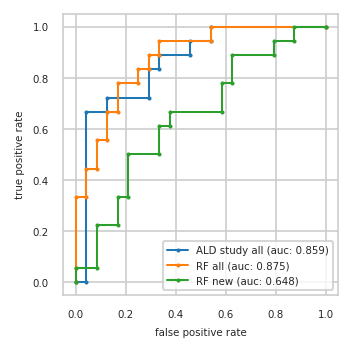

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.667  0.000 0.333  0.083 0.056
3          0.125 0.667  0.042 0.333  0.083 0.222
4          0.125 0.722  0.042 0.444  0.167 0.222
5          0.292 0.722  0.083 0.444  0.167 0.333
6          0.292 0.833  0.083 0.556  0.208 0.333
7          0.333 0.833  0.125 0.556  0.208 0.500
8          0.333 0.889  0.125 0.667  0.333 0.500
9          0.458 0.889  0.167 0.667  0.333 0.611
10         0.458 0.944  0.167 0.778  0.375 0.611
11         0.542 0.944  0.250 0.778  0.375 0.667
12         0.542 1.000  0.250 0.833  0.583 0.667
13         1.000 1.000  0.292 0.833  0.583 0.778
14           NaN   NaN  0.292 0.889  0.625 0.778
15           NaN   NaN  0.333 0.889  0.625 0.889
16           NaN   NaN  0.333 0.944  0.792 0.889
17           NaN   NaN  0.542 0.944  0.792 0.944
18           NaN   NaN  0.542 1.000  0.875 0.944
19           NaN   NaN  1.000 1.000  0.875 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q6MZW2,Q9GZT8;Q9GZT8-2,G3V295;G3V3I1;G3V5Z7;P60900
2,P02741,E7EN89;E9PP67;E9PQ25;F2Z2Y8;Q9H0E2;Q9H0E2-2,P10745
3,P61981,P02741,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,P14174,P61981,P31150
5,P04075,Q9Y2T3;Q9Y2T3-3,E9PK25;G3V1A4;P23528
6,Q9Y2T3;Q9Y2T3-3,P04075,P31321
7,Q99983,P14174,Q96GD0
8,A0A0C4DGY8;D6RA00;Q9UHY7,Q14894,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


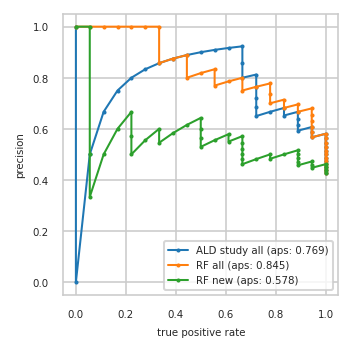

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.462 0.667
17         0.640 0.889     0.680 0.944     0.480 0.667
18         0.667 0.889     0.667 0.889     0.500 0.667
19         0.652 0.833     0.696 0.889     0.522 0.667
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.650 0.722     0.700 0.778     0.550 0.611
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.722 0.722     0.778 0.778     0.556 0.556
25         0.765 0.722     0.765 0.722     0.529 0.500
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.857 0.667     0.786 0.611     0.643 0.500
29         0.923 0.667     0.769 0.556     0.615 0.444
30         0.917 0.611     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.800 0.444     0.600 0.333
33         0.889 0.444     0.889 0.444     0.556 0.278
34         0.875 0.389     0.875 0.389     0.500 0.222
35         0.857 0.333     0.857 0.333     0.571 0.222
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


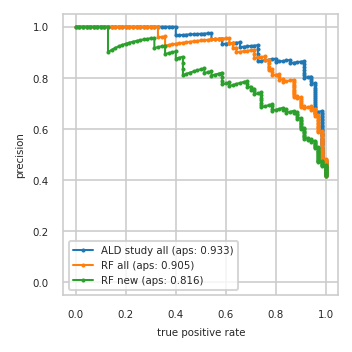

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


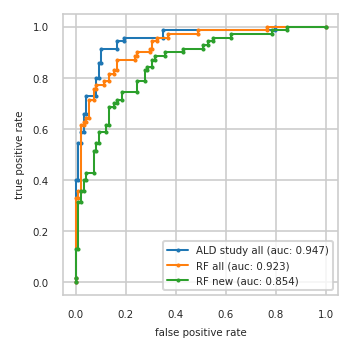

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}